## Лабораторная работа №3. Многомерный фильтр Калмана
**Цель работы** - спроектировать динамическую модель процесса по варианту и применить многомерный фильтр Калмана для нахождения оценок вектора состояния, а также различные метрики точности при использовании различных настроек ФК


## Теоретические сведения
Обощенная блок-схема работы многомерного фильтра Калмана для линейной динамической системы представлена на рисунке ниже

![](https://drive.google.com/uc?export=view&id=1DtxEWzOYSNlKWg2A2hJDQv-ujkfv4uIm)

## Задание лабораторной работы
1.   Написать функцию по генерации истинных значений процесса и  измерений по заданию из варианта. Сохранить истинные значения и измерения в отдельных файлах.
2.   Реализовать функцию работы многомерного Фильтра Калмана, куда можно передавать файл с истинными значениями, файл с измерениями, начальные значения вектора оценки и ковариационной матрицы, а также векторы дисперсий матриц ошибки процесса и погрешности измерений $R, Q$. Пусть погрешности элементов вектора состояния и измерения не коррелированы. Функция должна сохранять результат работы ФК в файл (вектор состояния на каждом шаге, основную диагональ матрицы ковариации, норма вектора инновации).
3.   Написать функцию, (1) реализующую последовательный запуск ФК с различными начальными параметрами. (2) Функция должна высчитывать такие метрики точности как максимальная погрешность, средняя погрешность, RMSE, а также строить график истинного значения, измерений и оценки параметра ФК с 95% доверительной границей. (3) Должен строиться график инновации.(4) Функция должна делать косвенный вывод о схождении работы ФК и времени схождения, для чего необходимо самостоятельно выбрать метрику схождения.
4.   Осуществить запуск не менее 5 наглядных конфигураций ФК, при которых фильтр может как сходиться, так и нет. Сохранить графики схождения ФК
4.   Написать вывод по работе функций и заполнить таблицу, в которой по строкам будут располагаться 5 вариантов запуска работы ФК, а по столбцам: начальные параметры запуска (перечислением), максимальная погрешность, средняя погрешность, RMSE, число итераций для схождения ФК (и заключение, если не сошелся)

7.   Написать выводы по всей работе.

## Варианты заданий
В таблице ниже представлены ссылки на описания заданий по вариантам, которые необходимо смоделировать при выполнении и сдаче лабораторной работы. Начальные значения и разброс значений выбрать самостоятельно.

| Вариант | Фамилии |
|---------|----|
| 1. [Описание варианта №1](https://colab.research.google.com/drive/1f8tDqL4yOv8G_X_IuHovsE0PxM--CaLq?usp=sharing) | Андронов, Голев, Миронов, Харламов |
| 2. [Описание варианта №2](https://colab.research.google.com/drive/1FAFiRJOIiwAZDvN93RayORONIrcKy6b_?usp=sharing) | Барыбин, Елманов, Слесарев, Чугунов |
| 3. [Описание варианта №3](https://colab.research.google.com/drive/12za9InaN3FoIGaJ6MYjIFGsiVcvS6v3B?usp=sharing) | Волков, Зинченко, Смирнов |
| 4. [Описание варианта №4](https://colab.research.google.com/drive/1iyrg0Hx2Mall04yhL_UyCq2xA7ii75Un?usp=sharing) |  Гасанов, Литвинов, Токарев |

In [69]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [70]:
print()

In [71]:
def generate_data(x0, y0, x_hat0, y_hat0, n):
    assert(n >= 200)

    t = np.arange(0, n)

    x_true = x0 + t * x_hat0
    y_true = y0 + t * y_hat0

    x_q_std = 0.5
    y_q_std = 0.5
    x_hat_q_std = 0.1
    y_hat_q_std = 0.1
    x_meas_std = 0.5
    y_meas_std = 0.5

    x_q = x_true + np.random.normal(0, x_q_std, len(t))
    y_q = y_true + np.random.normal(0, y_q_std, len(t))
    x_hat_q = x_hat0 + np.random.normal(0, x_hat_q_std, len(t))
    y_hat_q = y_hat0 + np.random.normal(0, y_hat_q_std, len(t))

    x_meas = x_q + np.random.normal(0, x_meas_std, len(t))
    y_meas = y_q + np.random.normal(0, y_meas_std, len(t))

    return (x_q, x_meas), (y_q, y_meas), x_hat_q, y_hat_q

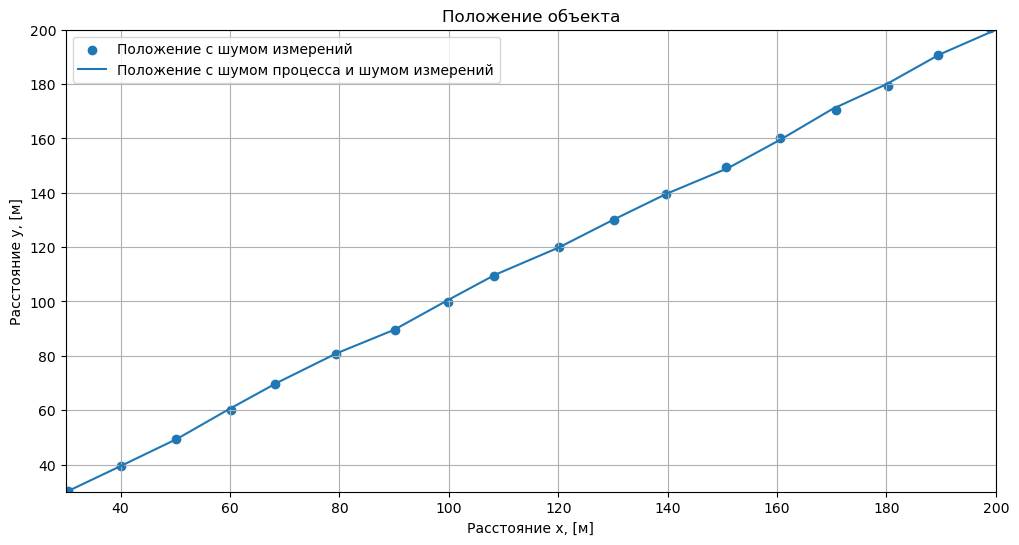

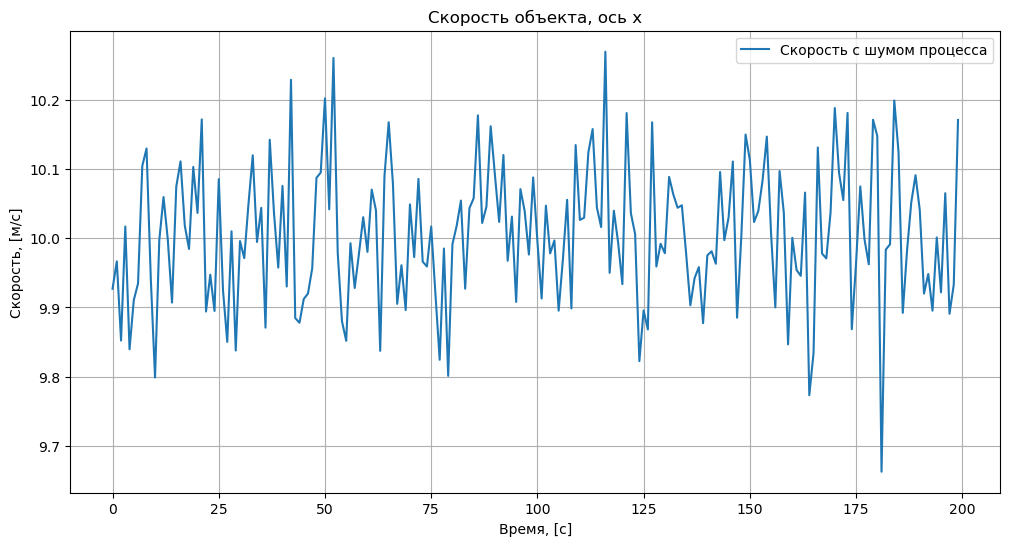

In [72]:
(x_q, x_meas), (y_q, y_meas), x_hat_q, y_hat_q = generate_data(10, 10, 10, 10, 200)

# Визуализация сгенерированных данных
t = range(0, 200)
plt.figure(figsize=(12, 6))
plt.scatter(x_meas, y_meas, label='Положение с шумом измерений')
plt.plot(x_q, y_q, label='Положение с шумом процесса и шумом измерений')
plt.xlabel('Расстояние x, [м]')
plt.ylabel('Расстояние y, [м]')
plt.legend()
plt.grid()
plt.title(f'Положение объекта')
plt.ylim(30, 200)
plt.xlim(30, 200)
plt.show()

# Визуализация сгенерированных данных
plt.figure(figsize=(12, 6))
plt.plot(t, x_hat_q, label='Скорость с шумом процесса')
plt.xlabel('Время, [с]')
plt.ylabel('Скорость, [м/с]')
plt.legend()
plt.grid()
plt.title(f'Скорость объекта, ось x')
plt.show()


In [ ]:

def kalman(z, F, R, P, H, x0 = None, B = None, Q = None):

  n = F.shape[1]
  m = H.shape[1]

  B = 0 if B is None else B
  Q = np.zeros(n) if Q is None else Q
  x = inv(H) * z[0] if x0 is None else x0

  while 
    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

IndentationError: unexpected indent (1291490065.py, line 10)